In [1]:
from tensorflow.keras.preprocessing.image import img_to_array  #for conversion into numpy arrary 
from tensorflow.keras.applications import MobileNetV2   #pretrained model which we will be using 
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Input,Dense
from tensorflow.keras.models import Model
from keras.models import Sequential

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import random  
import cv2
import os

In [2]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from imutils import paths   #from imutils module we are importing paths
#benefit of path is that we will give the directory input path and if that directory contains sub-directory
#then those sub-directory can be access very easily instead of providing very directory individually 

In [4]:
imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/orange_dataset_new/dataset/train")))
#print('type of imagePaths',type(imagePaths))
#print('content of imagePaths',imagePaths)

# random shuffle
random.seed(20) #since we are using seed() then it will generate pseudo-random number in easy words
                #it will always give us same random output every time even running the same code for thousand
                #times. 

        
random.shuffle(imagePaths) #this particular function will help us to geneate randomness within the list of 
                    #images and it will create changes within the original list. 

data = []
labels = []
image_dims = (224, 224, 3) #with the help of this i would change every image to this dimension

for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image,(image_dims[1], image_dims[0]))
    image = img_to_array(image) #converting the image to array for keras api
    data.append(image) #all the image data stored in data list
    l = label = imagePath.split(os.path.sep)[-2].split("_") #here we are extracting the name of the label 
    labels.append(l) #here are storing every labels name of every image in the labels list
                    #and labels and data list have one to one correspondance
print("Size of data list",len(data))   
print("Size of labels list",len(labels))
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("{} images ({:.2f}MB)".format(len(imagePaths), data.nbytes / (1024 * 1000.0)))
unique_names=np.unique(labels)
print(unique_names)

Size of data list 804
Size of labels list 804
804 images (945.50MB)
['blackspot' 'canker' 'fresh' 'grenning']


In [5]:
data = np.array(data)
label = np.array(labels)
#print(data)

In [6]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)
# total 4 labels
print("class labels:")
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

class labels:
1. blackspot
2. canker
3. fresh
4. grenning


In [7]:
def MobileNetV2_model(learning_rate, input_shape,class_number):
    baseModel = MobileNetV2(include_top=False, input_tensor=Input(shape=input_shape))
    for layer in baseModel.layers[:-4]:
        layer.trainable = False
   
    model = Sequential()
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(class_number, activation='softmax'))

    return model

In [8]:
bs = 32   #batch size
lr = 0.0001 #learning Rate 
size = (224, 224)
shape = (224,224, 3)  #the shape which we have used for every image and we also resized every image to this size
epochs = 10
class_number = 4 #number of classes we are using for this project 3 defect and 1 healthy 

In [9]:
model = MobileNetV2_model(lr,shape,class_number) #here we have get the corresponding model 
model.compile(loss= "categorical_crossentropy", metrics=["accuracy"], optimizer="adam") #model compliled 
#print(model)

9406464/9406464 [==============================] - 0s 0us/step


In [10]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20) #data and lables as already 
#been defined and are basically are the data and lables of those images 
#print(trainX)
#print(trainX[0])

In [11]:
print("[INFO] training ...")
H = model.fit(trainX, trainY, batch_size=8,steps_per_epoch=len(trainX) // 32,validation_data=(testX, testY),validation_steps=len(testX) // 32,epochs=50)
#trainning loss,trainning accuracy,validation loss and validation accuracy

#we are reducing the batch size from 32 to 8 
#after having batch size of 32 and after having the change within the size of the data 
#we are getting a huge level of different within the graph of trainning and validation

[INFO] training ...
Epoch 1/50
20/20 [==============================] - 19s 556ms/step - loss: 3.4423 - accuracy: 0.5688 - val_loss: 0.5720 - val_accuracy: 0.8500
Epoch 2/50
20/20 [==============================] - 10s 512ms/step - loss: 1.2435 - accuracy: 0.8000 - val_loss: 0.4247 - val_accuracy: 0.8500
Epoch 3/50
20/20 [==============================] - 10s 515ms/step - loss: 1.1430 - accuracy: 0.7875 - val_loss: 0.6281 - val_accuracy: 0.8750
Epoch 4/50
20/20 [==============================] - 10s 490ms/step - loss: 1.0003 - accuracy: 0.7875 - val_loss: 0.5807 - val_accuracy: 0.8500
Epoch 5/50
20/20 [==============================] - 10s 496ms/step - loss: 0.6027 - accuracy: 0.8258 - val_loss: 0.1695 - val_accuracy: 0.9500
Epoch 6/50
20/20 [==============================] - 14s 702ms/step - loss: 0.3987 - accuracy: 0.8313 - val_loss: 0.2287 - val_accuracy: 0.9250
Epoch 7/50
20/20 [==============================] - 10s 517ms/step - loss: 0.5223 - accuracy: 0.8500 - val_loss: 0.2056 - 

In [12]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=8)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=mlb.classes_))

[INFO] evaluating network...
21/21 [==============================] - 9s 314ms/step
[1 0 0 2 2 3 1 1 3 0 1 2 3 3 1 1 3 0 3 1 0 0 3 2 3 1 1 1 1 1 3 3 0 1 3 2 3
 1 3 1 0 2 1 0 3 0 2 2 1 3 2 3 1 0 1 3 2 1 1 1 1 3 1 0 1 3 2 3 2 0 0 2 3 0
 0 1 0 0 3 2 0 0 1 0 0 2 0 1 2 0 1 0 3 1 2 2 3 2 2 1 3 2 1 3 3 1 3 1 3 1 2
 1 1 0 1 1 3 3 2 3 1 3 3 1 1 1 1 1 3 2 1 3 1 0 0 3 1 1 2 1 2 0 3 1 3 2 3 0
 3 1 3 2 1 2 0 3 3 1 3 3 3]
              precision    recall  f1-score   support

   blackspot       0.97      0.83      0.90        36
      canker       0.89      0.98      0.93        49
       fresh       1.00      1.00      1.00        29
    grenning       1.00      1.00      1.00        47

    accuracy                           0.96       161
   macro avg       0.96      0.95      0.96       161
weighted avg       0.96      0.96      0.96       161



In [13]:
#print("[INFO] saving orange detector model...")
model.save("/content/drive/MyDrive/model_creation/Orange_MobileNetV2.model", save_format="h5")
model.save("/content/drive/MyDrive/model_creation/Orange_MobileNetV2tf.model", save_format="tf")

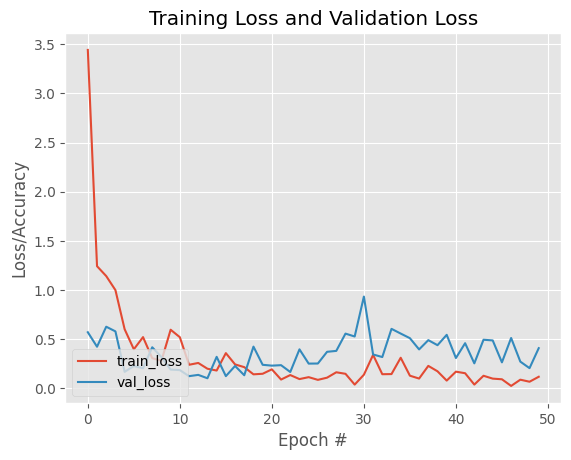

In [14]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

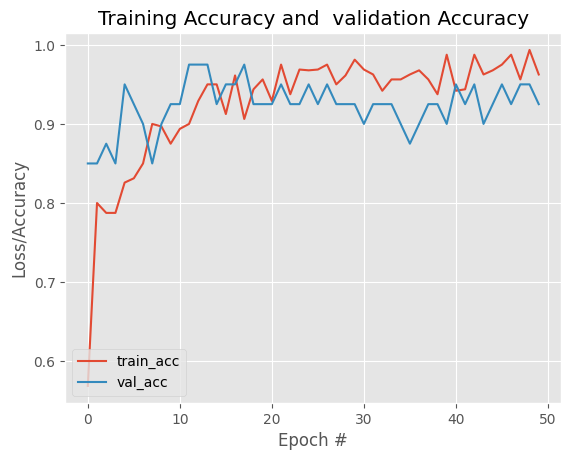

In [15]:
N = 50
plt.style.use("ggplot")
plt.figure()
#plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy and  validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [16]:

def model_predict(input_image,model) :
    # data1=[[]]
    # img=cv2.resize(input_image,(image_dims[1], image_dims[0]))
    # img = img_to_array(img)
    # data1[0]=img
    # data1 = np.array(data1, dtype="float") / 255.0
    x=model.predict(input_image)
    x = np.argmax(x, axis=1)
    return x

    

In [21]:
#loading the model 
from tensorflow.keras.models import load_model
model_path="/content/drive/MyDrive/model_creation/Orange_MobileNetV2tf.model"
model=load_model(model_path)
#model._make_predict_function()
#model.summary()

input_image=input("Enter the image ")

input_image=cv2.imread(input_image)
preds_value=model_predict(input_image,model)

print(preds_value)

if(preds_value==[0]) :
    print("BlackSpot disease ")
elif preds_value==[1] :
    print('Canker Disease')
elif preds_value==[2] :
    print('Fresh Orange')
elif preds_value ==[3]:
    print('grenning disease')
    

Enter the image /content/drive/MyDrive/orange_dataset_new/dataset/test/canker/cancro_teste (102).jpg


1/1 [==============================] - 1s 885ms/step
[1]
Canker Disease
